<a href="https://colab.research.google.com/github/dezlorator1/DSS/blob/main/multispectral_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# READ ME
## Для обучения и обрабоки нужно по 2 фотографии со спутника Sentinel 1 в формате PNG и разрешении 2400х1000 пикселей. Первая фотография в спектре linear gamma0, вторая SAR urban.
1. Подключить свой гугл диск, назвать фотографии x, y, x_test, y_test и поместить их в своем диске в папке img.
2. Превратить фотографии y и y_test в четырехцветные. Для этого запустить функцию сначала для y и сохранить как y_4color, потом для y_test и сохранить как y_4color_test
3. Нажать на кнопки в блоке заготовка данных
4. Нажать на кнопки в блоке нейросеть

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization,Activation,MaxPooling2D
from PIL import Image
from google.colab import drive
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from io import BytesIO  
from keras.constraints import maxnorm

In [ ]:
#Подключение гугл диска
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Превращение фотографии в 4 цвета
rgb = Image.open(r'/content/drive/MyDrive/img/y_test.png')
for x in range(2400):
  for y in range(1000):
    val = rgb.getpixel((x, y))
    r, g, b, all = val
    if(r>200 and g>200 and b> 200):
      rgb.putpixel((x, y), (255, 255, 255))
    elif (g>100):
      rgb.putpixel((x, y), (0, 255, 0))
    elif ((r > 100 or b> 100) and g<100):
      rgb.putpixel((x, y), (255, 0 , 0)) 
    else :
      rgb.putpixel((x, y), (0, 0 , 0))
rgb  
rgb.save(r'/content/drive/MyDrive/img/' + 'y_4color_test.png', 'PNG')

ЗАГОТОВКА ДАННЫХ

In [ ]:
#Тренировочные x
img_x = Image.open(r'/content/drive/MyDrive/img/x.png')
x_arr = np.zeros(shape=(2400000,3), dtype='f')
count = 0

for x in range(2400):
  for y in range(1000):
    val = img_x.getpixel((x, y))
    r, g, b, a = val
    x_arr[count][0] = r / 255
    x_arr[count][1] = g / 255
    x_arr[count][2] = b / 255
    count = count + 1 

In [ ]:
#Тренировочные y
img_4color = Image.open(r'/content/drive/MyDrive/img/y_4color.png')
y_arr = np.zeros(shape=(2400000,1), dtype='i')
count = 0

for x in range(2400):
  for y in range(1000):
    val = img_4color.getpixel((x, y))
    r, g, b, a = val
    if (r<50 and g>220 and b<50):
      y_arr[count] = 1
    elif (r>220 and g<50 and b<50):
      y_arr[count] = 2
    elif (r<50 and g<50 and b<50):
      y_arr[count]= 3

    count = count + 1 

In [ ]:
#Тестовые x
img_x = Image.open(r'/content/drive/MyDrive/img/x_test.png')
test_x_arr = np.zeros(shape=(2400000,3), dtype='f')
count = 0

for x in range(2400):
  for y in range(1000):
    val = img_x.getpixel((x, y))
    r, g, b, a = val
    test_x_arr[count][0] = r / 255
    test_x_arr[count][1] = g / 255
    test_x_arr[count][2] = b / 255
    count = count + 1 

In [ ]:
#Тестовые y
img_4color_test = Image.open(r'/content/drive/MyDrive/img/y_4color_test.png')
test_y_arr = np.zeros(shape=(2400000,1), dtype='i')
count = 0

for x in range(2400):
  for y in range(1000):
    val = img_4color_test.getpixel((x, y))
    r, g, b, a = val
    if (r<50 and g>220 and b<50):
      test_y_arr[count] = 1
    elif (r>220 and g<50 and b<50):
      test_y_arr[count] = 2
    elif (r<50 and g<50 and b<50):
      test_y_arr[count]= 3

    count = count + 1 

НЕЙРОСЕТЬ

In [ ]:
#Модель нейросети
model = keras.Sequential([
    Dense(3, activation = "relu",input_shape=(3,)),
    Dense(32, activation='softmax'),
    Dropout(0.4),
    Dense(16, activation='softmax'),
    Dropout(0.4),

    Dense(4, activation='relu')
])

In [ ]:
print(model.summary()) 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 32)                128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 68        
Total params: 736
Trainable params: 736
Non-trainable params: 0
________________________________________________________

In [ ]:
#Компиляция модели
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
#Обучение модели
model.fit(x_arr, y_arr, batch_size=32, epochs=2, validation_split=0.10)

Epoch 1/2
67500/67500 [==============================] - 111s 2ms/step - loss: 0.7712 - accuracy: 0.6754 - val_loss: 0.6549 - val_accuracy: 0.6978
Epoch 2/2
67500/67500 [==============================] - 111s 2ms/step - loss: 0.6763 - accuracy: 0.6969 - val_loss: 0.6518 - val_accuracy: 0.6996


In [ ]:
#Оценка точности модели
model.evaluate(test_x_arr, test_y_arr)

In [ ]:
#Создание массива предсказаний
predictions = model.predict(test_x_arr)

In [ ]:
predictions

array([[0.        , 0.        , 0.03921378, 0.16871384],
       [0.        , 0.        , 0.03197923, 0.17466483],
       [0.        , 0.        , 0.03035877, 0.17892876],
       ...,
       [0.        , 0.        , 0.03206892, 0.69652694],
       [0.        , 0.        , 0.03206892, 0.6965271 ],
       [0.        , 0.        , 0.03206892, 0.6965271 ]], dtype=float32)

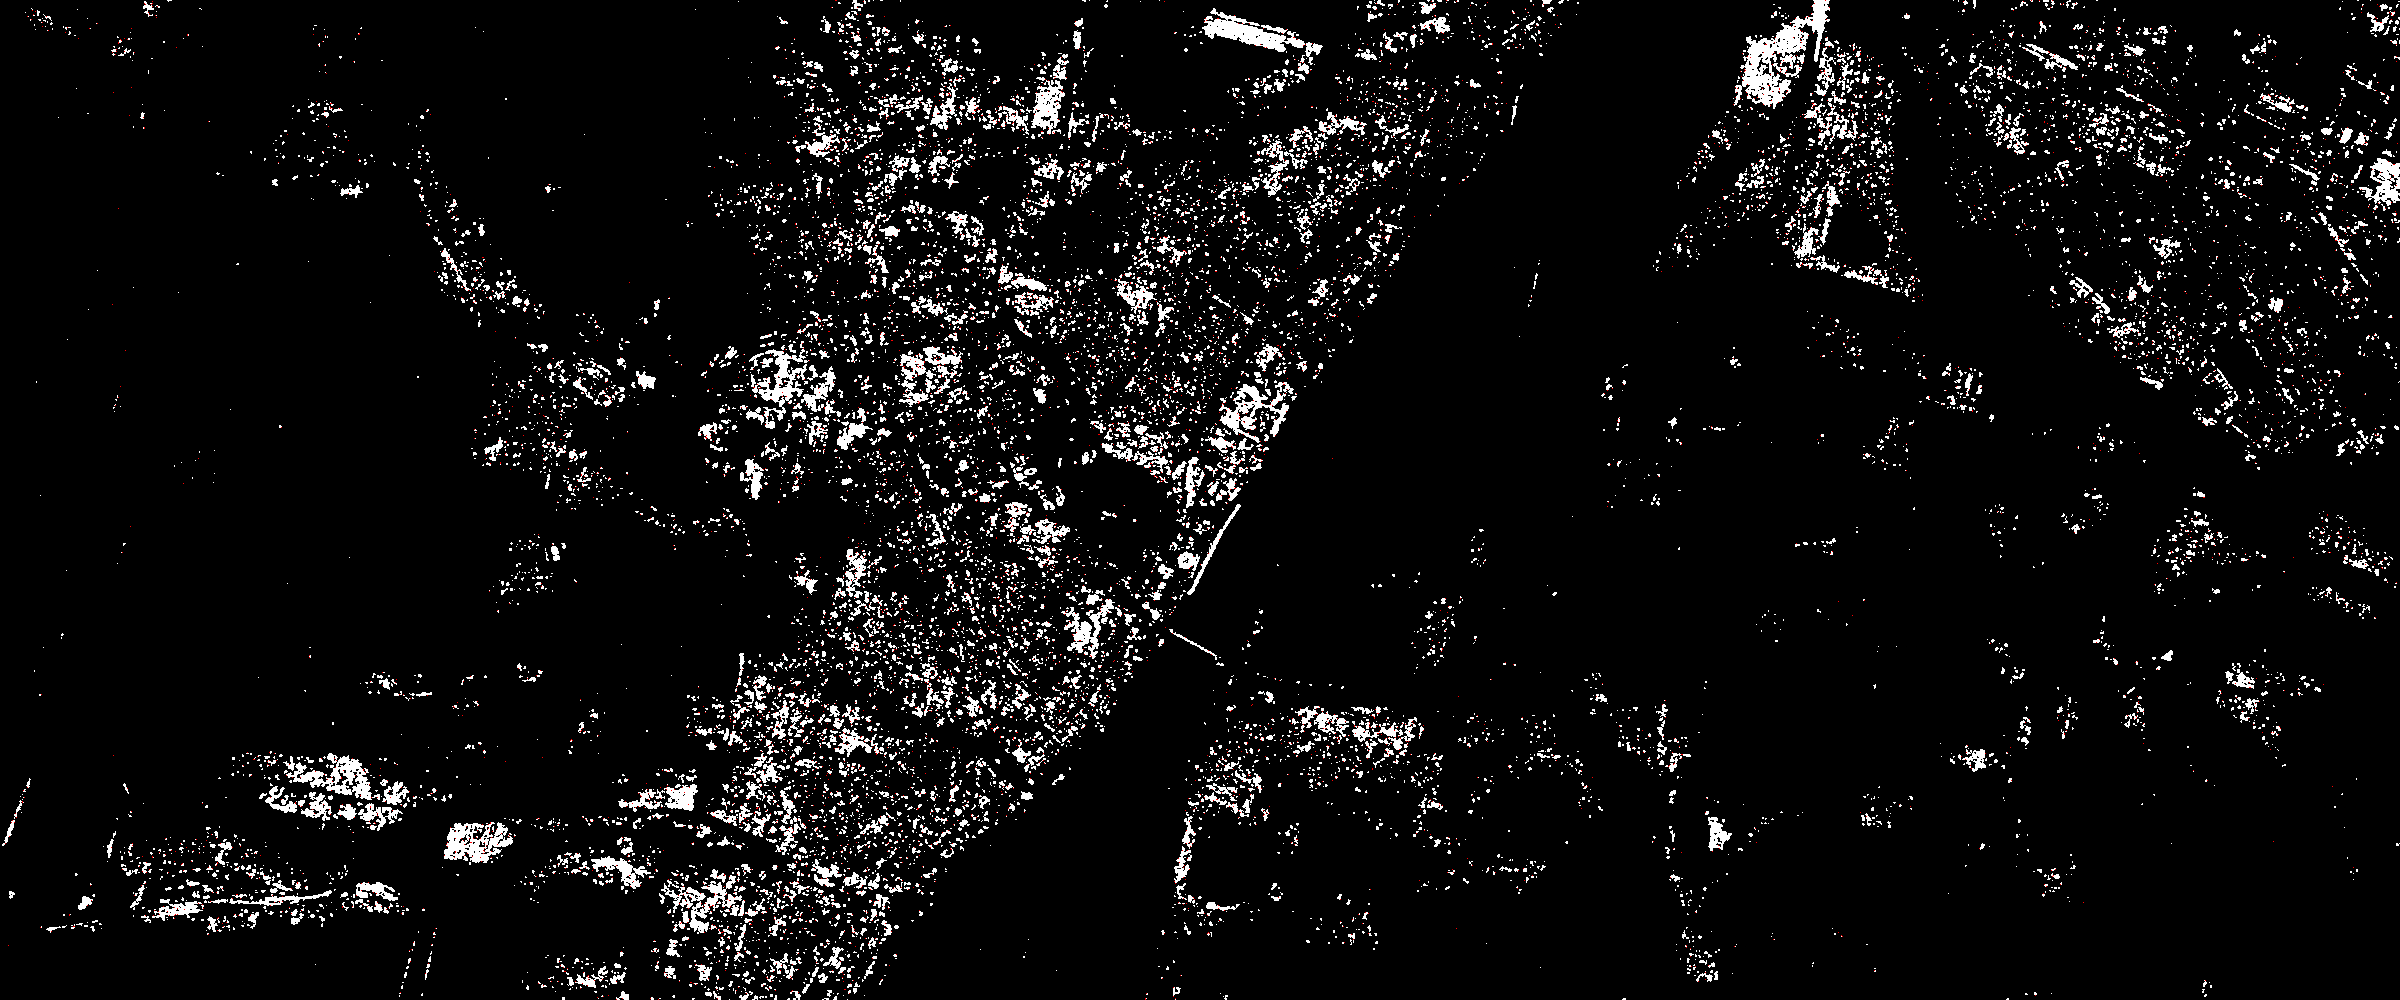

In [ ]:
#Отрисовка результата
img = Image.new('RGB', (2400, 1000))
#img = Image.open(r'/content/drive/MyDrive/img/x_test.png')
count = 0;
for x in range(2400):
  for y in range(1000):
    a = predictions[count]
    max = np.argmax(a)
    if (max == 0):
      img.putpixel((x, y), (255, 255 , 255)) 
    elif (max == 1):
      img.putpixel((x, y), (0, 255 , 0)) 
    elif (max == 2):
      img.putpixel((x, y), (255, 0 , 0)) 
    else:
      img.putpixel((x, y), (0, 0 , 0))
    count = count + 1   
img      